In [10]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import os
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [5]:
# meta data
cluster_meta=pd.read_csv('./data/TableS7-cell_metadata.csv',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('./data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


# immediately early genes

<AxesSubplot: xlabel='gene_name', ylabel='celltype'>

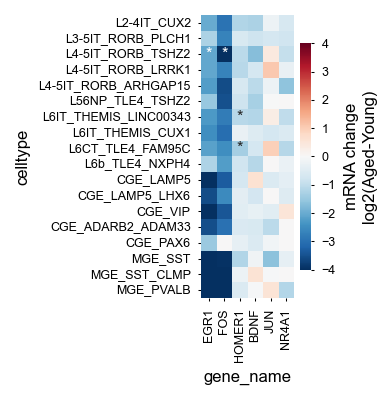

In [6]:
IEGs=['EGR1','FOS','HOMER1','BDNF','JUN','NR4A1']#,'ARC'

fulldata=pd.read_csv('./data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata['logFDR']=-np.log10(fulldata['adj.P.Val'])
df_z=fulldata[fulldata['gene_name'].isin(IEGs)].pivot(index='gene_name',columns='celltype',values='logFC').fillna(0).loc[IEGs,level2_order].T
df_p=fulldata[fulldata['gene_name'].isin(IEGs)].pivot(index='gene_name',columns='celltype',values='adj.P.Val').fillna(1).loc[IEGs,level2_order].T
plt.figure(figsize=(1,2.5),dpi=dpi)
sns.heatmap(df_z,cmap='RdBu_r',center=0,vmin=-4,vmax=4, mask=df_p<0.05, cbar=False)
sns.heatmap(df_z,cmap='RdBu_r',center=0,vmin=-4,vmax=4, mask=df_p>0.05,annot=np.repeat('*',df_z.shape[0]*df_z.shape[1]).reshape(df_z.shape[0],df_z.shape[1]),fmt="",cbar_kws={'shrink':0.8,'label':f'mRNA change\nlog2(Aged-Young)'})

# DMRs enrichment

In [ ]:
# def suffleDMRs(dmrfile,features):
#     import pybedtools
#     shufflesummary=pd.DataFrame(columns=['z','p'],index=features)
#     fig,axs=plt.subplots(3,5)
#     for n,feature in enumerate(features):
#         # print(feature)
#         featurefile=f'/cndd2/jchien/iGenome/chromhmm/E073_15_coreMarks_hg38lift_stateno_{feature}.bed.gz'
#         dmr = pybedtools.BedTool(dmrfile).merge()
#         region = pybedtools.BedTool(featurefile).merge()
#         dmr_and_region = dmr.intersect(region)
#         if len(dmr_and_region)>0:
#             dmr_and_region=pd.read_table(dmr_and_region.fn,header=None)
#             dmr_and_region=dmr_and_region.rename(columns={0:'chr',1:'start',2:'end'})
#             dmr_and_region['length']=dmr_and_region['end']-dmr_and_region['start']
#             n0=dmr_and_region['length'].sum()
#         else:
#             n0=0

#         # shuffle
#         ns=[]
#         for i in range(1000):
#             dmr_s = dmr.shuffle(genome='hg38',chrom=True,noOverlapping=True,excl='/cndd2/jchien/iGenome/hg38-blacklist.v2.bed.gz',seed=i)
#             dmr_and_region = dmr_s.intersect(region)
#             if len(dmr_and_region)>0:
#                 dmr_and_region=pd.read_table(dmr_and_region.fn,header=None)
#                 dmr_and_region=dmr_and_region.rename(columns={0:'chr',1:'start',2:'end'})
#                 dmr_and_region['length']=dmr_and_region['end']-dmr_and_region['start']
#                 ns.append(dmr_and_region['length'].sum())
#             else:
#                 ns.append(0)

#         # fit normal distribution
#         mu, std = sc.stats.norm.fit(ns)
#         if (std>0) & (n0>=0):
#             z=(n0-mu)/std
#             if z>0:
#                 p_values=(n0<np.array(ns)).sum()/len(ns)
#             else:
#                 p_values=(n0>np.array(ns)).sum()/len(ns)
#         else:
#             z=np.nan
#             p_values=np.nan
#         shufflesummary.loc[feature]=[z,p_values]
#         ax=axs[n//5,n%5]
#         ax.hist(ns,alpha=0.5)
#         ax.axvline(x=n0,c='r')
#         ax.set_title(f'{feature},{z:.1f},{p_values:.2f}')
#         plt.suptitle(dmrfile)
#         plt.tight_layout()
#         sample=dmrfile.split('/')[-1].replace('DMR-Age+Sex_AvsY_','')
#         plt.savefig(f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/ageDMR_enrichment_shuffledist_{sample}.pdf',bbox_inches='tight',dpi=dpi) 
#         shufflesummary.to_csv(f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/ageDMR_enrichment_shuffle_{sample}.tsv',sep='\t')
#     return shufflesummary

# ## ageDMR up
# df=pd.DataFrame(columns=pd.MultiIndex.from_product([level2_order, ['z','p']]))
# features=['1_tssa','2_tssaflnk','3_txflnk','4_tx','5_txwk','6_enhg','7_enh','8_znf','9_het',
#           '10_tssbiv','11_bivflnk','12_enhbiv','13_reprpc','14_reprpcwk','15_quies']
# dmrfiles=glob.glob('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/DMR-Age+Sex_AvsY_*_smoothed_p0.01_upinage.tsv.gz')
# for dmrfile in tqdm(dmrfiles):
#     celltype=dmrfile.split('/')[-1].replace('DMR-Age+Sex_AvsY_','').replace('_smoothed_p0.01_upinage.tsv.gz','')
#     df[celltype]=suffleDMRs(dmrfile,features)
# df.to_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/permutation_up2.tsv.gz',sep='\t')

# ## ageDMR down
# df=pd.DataFrame(columns=pd.MultiIndex.from_product([level2_order, ['z','p']]))
# features=['1_tssa','2_tssaflnk','3_txflnk','4_tx','5_txwk','6_enhg','7_enh','8_znf','9_het',
#           '10_tssbiv','11_bivflnk','12_enhbiv','13_reprpc','14_reprpcwk','15_quies']
# dmrfiles=glob.glob('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/DMR-Age+Sex_AvsY_*_smoothed_p0.01_downinage.tsv.gz')
# for dmrfile in tqdm(dmrfiles):
#     celltype=dmrfile.split('/')[-1].replace('DMR-Age+Sex_AvsY_','').replace('_smoothed_p0.01_downinage.tsv.gz','')
#     df[celltype]=suffleDMRs(dmrfile,features)
# df.to_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/permutation_down.tsv.gz',sep='\t')

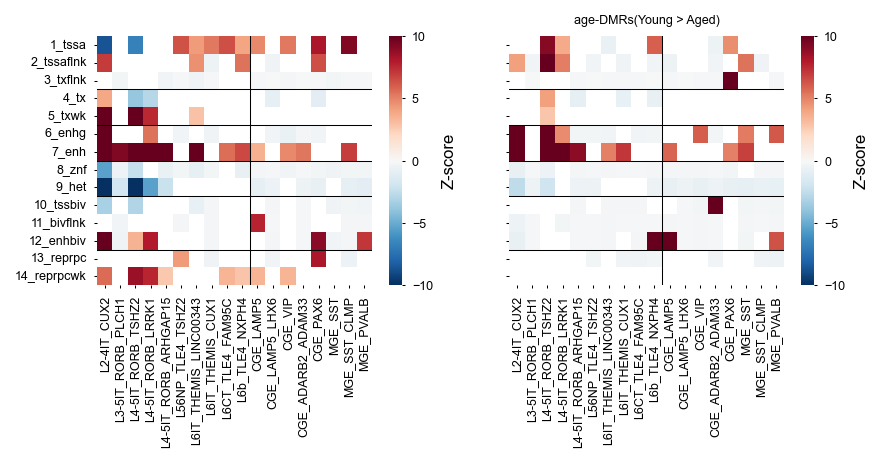

In [13]:
features=['1_tssa','2_tssaflnk','3_txflnk','4_tx','5_txwk','6_enhg','7_enh','8_znf','9_het',
          '10_tssbiv','11_bivflnk','12_enhbiv','13_reprpc','14_reprpcwk']

fig,axs=plt.subplots(1,2,figsize=(6.5,2.2),sharey=True,dpi=dpi)

ax=axs[0]
df=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/permutation_up.tsv.gz',sep='\t',index_col=0,header=[0,1])
df_z=df.xs('z',level=1,axis=1).fillna(0)
df_p=df.xs('p',level=1,axis=1).fillna(1)

# FDR correction
df_p=pd.DataFrame(fdrcorrection(df_p.values.flatten())[1].reshape(df_z.shape[0],df_z.shape[1]))
df_p.columns=df_z.columns
df_p.index=df_z.index
df_n=pd.DataFrame(index=level2_order)
df_n['n']=0
for i in level2_order:
    dmrfile=f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/DMR-Age+Sex_AvsY_{i}_smoothed_p0.01_upinage.tsv.gz'
    if os.path.isfile(dmrfile):
        n=len(pd.read_csv(dmrfile))
        df_n.loc[i]['n']=n
df_n['name']=df_n.index+" ("+df_n['n'].astype('str')+")"

order=[]
for i in level2_order:
    if df_n.loc[i]['n']>20:
        order.append(i)

sns.heatmap(df_z.loc[features,order],cmap='RdBu_r', center=0, mask=df_p.loc[features,order]>0.01, vmin=-10, vmax=10,cbar_kws={'label': 'Z-score','ticks':[-10,-5,0,5,10]},ax=ax)
ax.axvline(x=10,c='k',linewidth=0.5)
[ax.axhline(y=i,c='k',linewidth=0.5) for i in [3,5,7,9,12]]

ax=axs[1]
df=pd.read_csv('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/permutation_down.tsv.gz',sep='\t',index_col=0,header=[0,1])
df_z=df.xs('z',level=1,axis=1).fillna(0)
df_p=df.xs('p',level=1,axis=1).fillna(1)

# FDR correction
df_p=pd.DataFrame(fdrcorrection(df_p.values.flatten())[1].reshape(df_z.shape[0],df_z.shape[1]))
df_p.columns=df_z.columns
df_p.index=df_z.index
df_n=pd.DataFrame(index=level2_order)
df_n['n']=0
for i in level2_order:
    dmrfile=f'/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/ageDMR/enrichment/DMR-Age+Sex_AvsY_{i}_smoothed_p0.01_downinage.tsv.gz'
    if os.path.isfile(dmrfile):
        n=len(pd.read_csv(dmrfile))
        df_n.loc[i]['n']=n
df_n['name']=df_n.index+" ("+df_n['n'].astype('str')+")"

order=[]
for i in level2_order:
    if df_n.loc[i]['n']>20:
        order.append(i)

sns.heatmap(df_z.loc[features,order],cmap='RdBu_r', center=0, mask=df_p.loc[features,order]>0.01, vmin=-10, vmax=10,cbar_kws={'label': 'Z-score','ticks':[-10,-5,0,5,10]},ax=ax)
ax.set_title('age-DMRs(Young > Aged)',fontsize=6)
ax.axvline(x=10,c='k',linewidth=0.5)
[ax.axhline(y=i,c='k',linewidth=0.5) for i in [3,5,7,9,12]]
plt.show()

# EGR1 enrichment

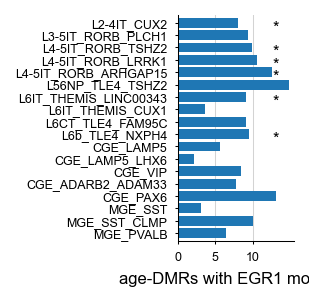

In [8]:
files=glob.glob('/cndd2/jchien/project/CZI_human/pseudobulk_allc/merge_CG/DMR/HOMER/*DMR-Age+Sex*hyper/knownResults.txt')
df=[]
sig_sorted=[]
for file in files:
    celltype=file.split('/')[-2].replace('DMR-Age+Sex_AvsY_','').replace('_smoothed_p0.01_hyper','')
    tmp=pd.read_csv(file,sep='\t',index_col=0)
    tmp=tmp.loc[['Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer']]
    tmp['% of Target Sequences with Motif']=tmp['% of Target Sequences with Motif'].str.replace('%','').astype(np.float)
    tmp['% of Background Sequences with Motif']=tmp['% of Background Sequences with Motif'].str.replace('%','').astype(np.float)
    tmp[celltype]=tmp['% of Target Sequences with Motif']#/tmp['% of Background Sequences with Motif']
    df.append(tmp[celltype])
    tmp[celltype]=tmp['q-value (Benjamini)']
    sig_sorted.append(tmp[celltype])
df=pd.DataFrame(df).loc[level2_order]
sig_sorted=pd.DataFrame(sig_sorted).loc[level2_order]
sig_sorted['sig']=False
sig_sorted.loc[sig_sorted['Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer']<0.05,'sig']=True
df.join(sig_sorted['sig']).sort_values(['sig','Egr1(Zf)/K562-Egr1-ChIP-Seq(GSE32465)/Homer'])

barplot = df.loc[::-1].plot(kind='barh',figsize=(1,2),width=0.8)
plt.xticks([0,5,10])
plt.grid(axis='x')
plt.xlabel('age-DMRs with EGR1 motif (%)')
plt.legend().remove()
for p,sig in zip(barplot.patches,sig_sorted['sig'].values[::-1]):
    if sig == True:
        barplot.annotate('*', (13,p.get_y()),
                    ha='center', va='center', fontsize=8, color='black')